C:\Users\BNCD\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Batch: 10/10000, Average Reward: 7.725
Batch: 20/10000, Average Reward: 8.817
Batch: 30/10000, Average Reward: 9.002
Batch: 40/10000, Average Reward: 9.030
Batch: 50/10000, Average Reward: 8.979
Batch: 60/10000, Average Reward: 9.143
Batch: 70/10000, Average Reward: 9.103
Batch: 80/10000, Average Reward: 9.183
Batch: 90/10000, Average Reward: 9.216
Batch: 100/10000, Average Reward: 9.206
Batch: 110/10000, Average Reward: 9.259
Batch: 120/10000, Average Reward: 9.183
Batch: 130/10000, Average Reward: 9.138
Batch: 140/10000, Average Reward: 9.197
Batch: 150/10000, Average Reward: 9.358
Batch: 160/10000, Average Reward: 9.416
Batch: 170/10000, Average Reward: 9.557
Batch: 180/10000, Average Reward: 9.680
Batch: 190/10000, Average Reward: 9.782
Batch: 200/10000, Average Reward: 9.784
Batch: 210/10000, Average Reward: 9.831
Batch: 220/10000, Average Reward: 9.980
Batch: 230/10000, Average Reward: 9.908
Batch: 240/10000, Average Reward: 9.981
Batch: 250/10000, Average Reward: 9.968
Batch: 26

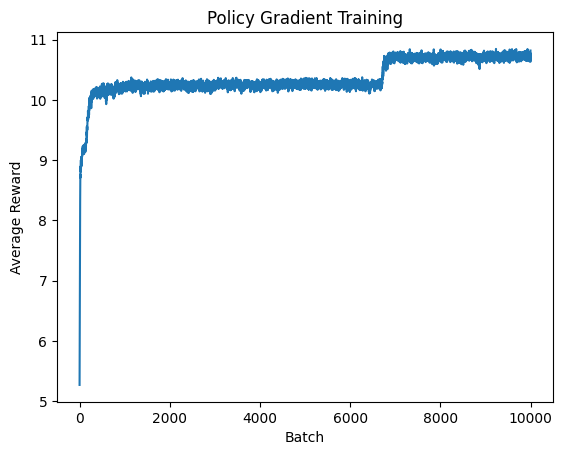

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

# Game parameters
num_cells = 8
num_reward_cells = 3
reward_range = (5.0, 10.0)

# Neural network parameters
hidden_layer_size = 512
batch_size = 128
num_batches = 10000
learning_rate = 0.001

# Create the policy network
model = Sequential([
    Dense(hidden_layer_size, input_shape=(num_cells,), kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5),
    Dense(num_cells, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Function to generate a game
def generate_game():
    game_state = np.zeros(num_cells)
    reward_indices = np.random.choice(num_cells, num_reward_cells, replace=False)
    game_state[reward_indices] = np.random.uniform(reward_range[0], reward_range[1], num_reward_cells)
    return game_state

# Function to calculate reward
def calculate_reward(game_state, action):
    if game_state[action] > 0:
        return game_state[action]
    else:
        left_index = (action - 1) % num_cells
        right_index = (action + 1) % num_cells
        if game_state[left_index] > 0 and game_state[right_index] > 0:
            return game_state[left_index] + game_state[right_index]
        else:
            return 0

# # Function to evaluate the policy
# def evaluate_policy(model, num_episodes=10000):
#     total_reward = 0
#     for _ in range(num_episodes):
#         game_state = generate_game()
#         probs = model(np.expand_dims(game_state, axis=0)).numpy()[0]
#         action = np.random.choice(num_cells, p=probs)
#         total_reward += calculate_reward(game_state, action)
#     return total_reward / num_episodes


# Function to evaluate the policy
def evaluate_policy(model, num_episodes=10000):
    total_reward = 0
    states = np.array([generate_game() for i in np.arange(num_episodes)])
    actions = model(states).numpy().argmax(axis = 1)
    for game_state, action in zip(states, actions):
        total_reward += calculate_reward(game_state, action)
    return total_reward / num_episodes


# Training loop
rewards_history = []
for batch in range(num_batches):
    states = np.array([generate_game() for i in np.arange(batch_size)])
    actions = [np.random.choice(num_cells, p=probs) for probs in model(states).numpy()]
    rewards = [calculate_reward(game_state, action) for game_state, action in zip(states, actions)]

    # Normalize rewards
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-8)

    with tf.GradientTape() as tape:
        probs = model(np.array(states))
        action_probs = tf.gather_nd(probs, [[i, a] for i, a in enumerate(actions)])
        log_probs = tf.math.log(action_probs)
        loss = -tf.reduce_mean(log_probs * rewards)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Evaluate the policy
    average_reward = evaluate_policy(model)
    rewards_history.append(average_reward)

    if (batch + 1) % 10 == 0:
        print(f"Batch: {batch + 1}/{num_batches}, Average Reward: {average_reward:.3f}")

# Plot the average reward over batches
plt.plot(range(num_batches), rewards_history)
plt.xlabel("Batch")
plt.ylabel("Average Reward")
plt.title("Policy Gradient Training")
plt.show()

In [15]:
state = generate_game()
state, model(np.array([state])).numpy()

(array([9.21996144, 0.        , 6.42935898, 0.        , 0.        ,
        0.        , 0.        , 5.48224935]),
 array([[1.2484423e-24, 1.0000000e+00, 8.8004627e-16, 1.8905890e-19,
         7.2334586e-16, 6.0583053e-22, 6.5675705e-17, 3.4924669e-19]],
       dtype=float32))

In [12]:
generate_game()

array([9.72143529, 0.        , 0.        , 0.        , 0.        ,
       6.87722155, 8.88267054, 0.        ])

In [16]:
def get_optimal_action_and_value(state):
    values = np.array([calculate_reward(state, action) for action in np.arange(8)])
    optimal_action = values.argmax()
    return optimal_action, values[optimal_action]

In [17]:
get_optimal_action_and_value(state)

(np.int64(1), np.float64(15.649320421695222))

In [38]:
states = np.array([generate_game() for i in np.arange(100)])

In [39]:
model(states).numpy().argmax(axis=1)

array([1, 6, 1, 7, 6, 1, 4, 1, 7, 7, 4, 4, 7, 7, 4, 1, 1, 4, 6, 7, 1, 6,
       7, 7, 7, 1, 1, 7, 1, 4, 6, 7, 1, 4, 4, 1, 1, 1, 4, 7, 1, 4, 1, 4,
       1, 4, 1, 1, 1, 4, 5, 1, 4, 6, 4, 1, 6, 1, 6, 1, 5, 4, 4, 1, 4, 4,
       1, 7, 6, 4, 5, 4, 7, 6, 6, 7, 6, 1, 7, 5, 4, 1, 4, 1, 7, 1, 1, 7,
       6, 5, 7, 1, 1, 1, 6, 5, 7, 7, 6, 1])

In [40]:
optacts = []
for i in np.arange(100):
    act, val = get_optimal_action_and_value(states[i])
    optacts.append(act)
np.array(optacts) == model(states).numpy().argmax(axis=1)

array([False,  True, False,  True, False, False, False,  True,  True,
        True, False, False,  True, False,  True,  True,  True, False,
        True,  True,  True, False, False,  True,  True, False, False,
        True, False,  True,  True, False,  True,  True, False, False,
        True,  True, False,  True, False, False, False, False,  True,
        True, False,  True,  True, False,  True,  True,  True, False,
       False, False,  True, False,  True, False,  True, False,  True,
       False,  True, False, False,  True, False,  True,  True, False,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False,  True, False,  True, False,  True, False,  True,
       False, False,  True,  True,  True,  True,  True,  True,  True,
       False])

In [41]:
states[0:1],  model(states[0:1]).numpy()

(array([[0.        , 5.79954866, 0.        , 8.67009046, 0.        ,
         0.        , 5.0774413 , 0.        ]]),
 array([[6.5882396e-13, 9.9632239e-01, 1.5202331e-27, 2.8722657e-13,
         1.2838633e-17, 4.3102086e-18, 3.6776215e-03, 1.0018639e-15]],
       dtype=float32))

In [29]:
calculate_reward(states[1], 7)

np.float64(18.112527820898286)

In [34]:
states = np.array([generate_game() for i in np.arange(10000)])
actions = model(states).numpy().argmax(axis=1)
np.mean([calculate_reward(state, action) for state, action in zip(states, actions)])

np.float64(10.056200509696135)

In [ ]:
_, get_optimal_action_and_value(state)

# gemini

Batch: 10/200, Average Reward: 4.634
Batch: 20/200, Average Reward: 4.986
Batch: 30/200, Average Reward: 5.231
Batch: 40/200, Average Reward: 5.529
Batch: 50/200, Average Reward: 5.927
Batch: 60/200, Average Reward: 6.501
Batch: 70/200, Average Reward: 7.134
Batch: 80/200, Average Reward: 7.547
Batch: 90/200, Average Reward: 7.812
Batch: 100/200, Average Reward: 7.995
Batch: 110/200, Average Reward: 8.018
Batch: 120/200, Average Reward: 8.363
Batch: 130/200, Average Reward: 8.402
Batch: 140/200, Average Reward: 8.565
Batch: 150/200, Average Reward: 8.729
Batch: 160/200, Average Reward: 8.842
Batch: 170/200, Average Reward: 8.745
Batch: 180/200, Average Reward: 8.915
Batch: 190/200, Average Reward: 9.055
Batch: 200/200, Average Reward: 9.140


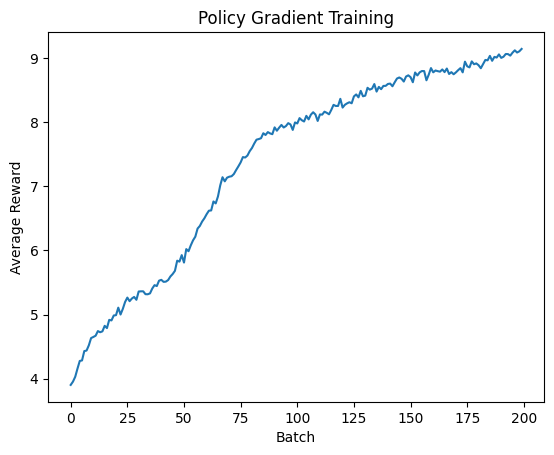

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, BatchNormalization, ReLU, Dropout
from tensorflow.keras.models import Sequential
import numpy as np
import matplotlib.pyplot as plt

# Game parameters
num_cells = 8
num_reward_cells = 3
reward_range = (5.0, 10.0)

# Neural network parameters
hidden_layer_size = 512
batch_size = 128
num_batches = 1000
learning_rate = 0.001

# Create the policy network
model = Sequential([
    Dense(hidden_layer_size, input_shape=(num_cells,), kernel_initializer='he_normal'),
    BatchNormalization(),
    ReLU(),
    Dropout(0.5)(),
    Dense(num_cells, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

# Function to generate a game
def generate_game():
    game_state = np.zeros(num_cells)
    reward_indices = np.random.choice(num_cells, num_reward_cells, replace=False)
    game_state[reward_indices] = np.random.uniform(reward_range[0], reward_range[1], num_reward_cells)
    return game_state

# Function to calculate reward
def calculate_reward(game_state, action):
    if game_state[action] > 0:
        return game_state[action]
    else:
        left_index = (action - 1) % num_cells
        right_index = (action + 1) % num_cells
        if game_state[left_index] > 0 and game_state[right_index] > 0:
            return game_state[left_index] + game_state[right_index]
        else:
            return 0

# # Function to evaluate the policy
# def evaluate_policy(model, num_episodes=10000):
#     total_reward = 0
#     for _ in range(num_episodes):
#         game_state = generate_game()
#         probs = model(np.expand_dims(game_state, axis=0)).numpy()[0]
#         action = np.random.choice(num_cells, p=probs)
#         total_reward += calculate_reward(game_state, action)
#     return total_reward / num_episodes
    
# Function to evaluate the policy
def evaluate_policy(model, num_episodes=10000):
    total_reward = 0
    states = np.array([generate_game() for i in np.arange(num_episodes)])
    actions = model(states).numpy().argmax(axis = 1)
    for game_state, action in zip(states, actions):
        total_reward += calculate_reward(game_state, action)
    return total_reward / num_episodes
    
# Training loop
rewards_history = []
for batch in range(num_batches):
    states = []
    actions = []
    rewards = []

    for _ in range(batch_size):
        game_state = generate_game()
        states.append(game_state)
        probs = model(np.expand_dims(game_state, axis=0)).numpy()[0]
        action = np.random.choice(num_cells, p=probs)
        actions.append(action)
        reward = calculate_reward(game_state, action)
        rewards.append(reward)

    # Normalize rewards
    rewards = (rewards - np.mean(rewards)) / (np.std(rewards) + 1e-8)

    with tf.GradientTape() as tape:
        probs = model(np.array(states))
        action_probs = tf.gather_nd(probs, [[i, a] for i, a in enumerate(actions)])
        log_probs = tf.math.log(action_probs)
        loss = -tf.reduce_mean(log_probs * rewards)

    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    # Evaluate the policy
    average_reward = evaluate_policy(model)
    rewards_history.append(average_reward)

    if (batch + 1) % 1 == 0:
        print(f"Batch: {batch + 1}/{num_batches}, Average Reward: {average_reward:.3f}")

# Plot the average reward over batches
plt.plot(range(num_batches), rewards_history)
plt.xlabel("Batch")
plt.ylabel("Average Reward")
plt.title("Policy Gradient Training")
plt.show()